# Monitoring problem

In [ ]:
'''
Set-up:
1) 100 states, 4 actions
2) 2 initial constraints
2) Infeasibile initial constraints
3) Use ResPG-PD, ResOPG-PD

'''

'\nSet-up:\n1) 100 states, 4 actions\n2) 2 initial constraints\n2) Infeasibile initial constraints\n3) Use ResPG-PD, ResOPG-PD\n\n'

In [ ]:
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import linprog

## Functions in the monitoring problem

In [ ]:
'''
Input: state number, length of the grid, width of the grid
Ouput: the coordinate of the state
'''
def state2coordinate(state, length, width):
  x = state//length
  y = state%width
  return x,y

'''
Input: the coordinate of the state, length of the grid, width of the grid
Ouput: state number
'''
def coordinate2state(x,y, length, width):
  if x<=length and x>=0 and y>=0 and y<=width:
    return x*length+y
  else:
    print("error")
    return np.inf

'''
Input: length of the grid, width of the grid
Output: transition matrix
'''
def gen_transition(length, width):
  prob_transition = np.zeros([length*width*4, length*width])
  for i in range(length):
    for j in range(width):
      for k in range(4):
        state = coordinate2state(i,j, length, width)
        # up
        if j+1<width:
          nextstate = coordinate2state(i,j+1, length, width)
          prob_transition[state*4][nextstate] = 1
        else:
          prob_transition[state*4][state] = 1

        # down
        if j-1>=0:
          nextstate = coordinate2state(i,j-1, length, width)
          prob_transition[state*4+1][nextstate] = 1
        else:
          prob_transition[state*4+1][state] = 1

        # left
        if i-1>=0:
          nextstate = coordinate2state(i-1,j, length, width)
          prob_transition[state*4+2][nextstate] = 1
        else:
          prob_transition[state*4+2][state] = 1

        # right
        if i+1<length:
          nextstate = coordinate2state(i+1,j, length, width)
          # print(i,j,nextstate)
          prob_transition[state*4+3][nextstate] = 1
        else:
          prob_transition[state*4+3][state] = 1

  return prob_transition

'''
Input: center coordinate of the area, radius of the area, length of the grid, width of the grid
Output: utility/reward matrix
'''

def gen_reward_utility(centerx, centery, radius, length, width):
  output = np.zeros(length*width*4)
  for i in range(length*width):
    x,y = state2coordinate(i, length, width)
    distance = ((x-centerx)**2+(y-centery)**2)**(0.5)
    if distance<=radius:
      output[i*4:i*4+4] = 1
  return output

'''
Input: inital distribution,length of the grid, width of the grid, center coordinate of the area, radius of the area,
Output: the maximum constraint to make the problem feasible
'''
def calculate_maxu(rho, length, width, centerx, centery, radius):
  umat = []
  for i in range(length*width):
    x,y = state2coordinate(i, length, width)
    distance = ((x-centerx)**2+(y-centery)**2)**(0.5)
    if distance<=radius:
      umat.append(np.array([x,y]))

  umat = np.array(umat)

  maxuxy = np.zeros(length*width)
  for i in range(length*width):
    x,y = state2coordinate(i, length, width)
    # print(np.sum(np.abs(umat-np.array([x,y])), axis=1))
    stepxy = np.min(np.sum(np.abs(umat-np.array([x,y])), axis=1))
    # print(stepxy)
    maxuxy[i] = (1/(1-gamma))*(gamma**stepxy)

  return maxuxy@rho





## Problem setting

In [ ]:
## Random Seed
np.random.seed(10)
## Problem Setup
length = int(10)
width = int(10)
gamma = 0.9
n, m = length*width, 4 # s, a
'''
Probability transition matrix
Each row sums up to one
'''

prob_transition = gen_transition(length, width)
'''
Rewards: time in S0
'''

reward = gen_reward_utility(4.5, 4.5, 1.6, length, width)

'''
Utilities: b1=1,b2=1.2
'''
uval1 = 1.0
uval2 = 1.2
utility1 = uval1*gen_reward_utility(1.5, 7.5, 1.6, length, width)
utility2 = uval2*gen_reward_utility(7.5, 1.5, 1.6, length, width)
'''
Start state distribution: uniform
'''
rho = 1/(length*width)*np.ones(length*width)

'''

'''
umax1 = uval1*calculate_maxu(rho, length, width, 1.5, 7.5, 1.6)
umax2 = uval2*calculate_maxu(rho, length, width, 7.5, 1.5, 1.6)
print('If the initial constraint for u1 is greater than '+ str(umax1)+ ', this constraint is infeasible.')
print('If the initial constraint for u2 is greater than '+ str(umax2)+ ', this constraint is infeasible.')

'''
2 initial constraints
'''
u_constraint1 = 7
u_constraint2 = 9

If the initial constraint for u1 is greater than 6.365445100946492, this constraint is infeasible.
If the initial constraint for u2 is greater than 7.63853412113579, this constraint is infeasible.


## Useful functions

In [ ]:
'''
Input: theta as an array and
Ouput: array of probabilites corresponding to each state: [\pi_{s_1}(.), ...., \pi_{s_n}(.)]
'''
def theta_to_policy(theta,n,m):
    prob = []
    for i in range(n):
        norm = np.sum(np.exp(theta[m*i:m*(i+1)]))
        for j in range(m*i,m*(i+1)):
            prob.append(np.exp(theta[j])/norm)

    return np.asarray(prob)


"""
Input: Discrete probability distributions p, q : array-like, dtype=float, shape=n
Output: Kullback-Leibler divergence D(p||q)
"""
def kl_div(p, q):
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)

    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [ ]:
'''
Get \Pi_{\pi}((s) -> (s,a)) in R^{|S| x |S||A|} matrix corresponding to the policy \pi using the prob vector
'''
def get_Pi(prob,n,m):
    Pi = np.zeros((n,n*m))
    for i in range(n):
        Pi[i,i*m:(i+1)*m] = prob[i*m:(i+1)*m]

    return Pi

In [ ]:
'''
The overall reward function \ell(\theta)
'''
def ell(qvals,prob,rho):
    V = np.zeros(n)
    for i in range(n):
        V[i] = np.sum([qvals[i*m + j]*prob[i*m + j] for j in range(m)])

    ell = np.dot(V,rho)
    return ell

In [ ]:
'''
Input: theta as an array and
Ouput: array of probabilites corresponding to each state: [\pi_{s_1}(.), ...., \pi_{s_n}(.)]
'''
def project_to_policy(theta,n,m):
    prob = []
    prob_pers = []
    for i in range(n):
#         norm = np.sum(np.exp(theta[m*i:m*(i+1)]))
        prob_pers = projection_simplex_sort(theta[m*i:m*(i+1)], z=1)
        for j in range(m):
            prob.append(prob_pers[j])

    return np.asarray(prob)

In [ ]:
'''
The projection function
Input: a scalar
Output: a scalar in the interval [0 C]
'''
def proj(scalar,gamma):
    offset = 1000/(1-gamma)
    if scalar < 0:
        scalar = 0

    if scalar > offset:
        scalar = offset

    return scalar

In [ ]:
"""
License: BSD
Author: Mathieu Blondel
Implements three algorithms for projecting a vector onto the simplex: sort, pivot and bisection.
For details and references, see the following paper:
Large-scale Multiclass Support Vector Machine Training via Euclidean Projection onto the Simplex
Mathieu Blondel, Akinori Fujino, and Naonori Ueda.
ICPR 2014.
http://www.mblondel.org/publications/mblondel-icpr2014.pdf
"""

def projection_simplex_sort(v, z=1):
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w


def projection_simplex_pivot(v, z=1, random_state=None):
    rs = np.random.RandomState(random_state)
    n_features = len(v)
    U = np.arange(n_features)
    s = 0
    rho = 0
    while len(U) > 0:
        G = []
        L = []
        k = U[rs.randint(0, len(U))]
        ds = v[k]
        for j in U:
            if v[j] >= v[k]:
                if j != k:
                    ds += v[j]
                    G.append(j)
            elif v[j] < v[k]:
                L.append(j)
        drho = len(G) + 1
        if s + ds - (rho + drho) * v[k] < z:
            s += ds
            rho += drho
            U = L
        else:
            U = G
    theta = (s - z) / float(rho)
    return np.maximum(v - theta, 0)


def projection_simplex_bisection(v, z=1, tau=0.0001, max_iter=1000):
    func = lambda x: np.sum(np.maximum(v - x, 0)) - z
    lower = np.min(v) - z / len(v)
    upper = np.max(v)

    for it in range(max_iter):
        midpoint = (upper + lower) / 2.0
        value = func(midpoint)

        if abs(value) <= tau:
            break

        if value <= 0:
            upper = midpoint
        else:
            lower = midpoint

    return np.maximum(v - midpoint, 0)

In [ ]:

'''
The projection function for xi
Input: a scalar
Output: a scalar in the interval [-C C]
'''


def proj_xi1(scalar, gamma):
    max = 0
    min = -2*uval1/(1-gamma)

    if scalar < min:
        scalar = min;
    if scalar > max:
        scalar = max

    return scalar

def proj_xi2(scalar, gamma):
    max = 0
    min = -2*uval2/(1-gamma)

    if scalar < min:
        scalar = min;
    if scalar > max:
        scalar = max

    return scalar



In [ ]:
'''
Input: theta as an array
Ouput: array of probabilites corresponding to each state: [\pi_{s_1}(.), ...., \pi_{s_n}(.)]
'''
def theta_to_policy_naive(theta,n,m):
    prob = []
    for i in range(n):
        norm = np.sum(theta[m*i:m*(i+1)])
        for j in range(m*i,m*(i+1)):
            prob.append(theta[j]/norm)

    return np.asarray(prob)

## Resilient Policy Gradient Primal-Dual (ResPG-PD) Method

In [ ]:
'''
Policy search via ResPG-PD
Input: n, m, prob_transition, gamma, reward, utility, stepsize, alpha, total_iterates, init_constraint, show_detail = True, optimal_policy = None
Output: function values of reward, utility and relaxation (show_detail == False)
    Vectors containing the values of reward, utility, relaxation and policy optimality gap during training process (show_detail == True)
'''


def NPG_primal_dual_resilient(n, m, prob_transition, gamma, reward, utility1, utility2,  stepsize, alpha, total_iterates, init_constraint1, init_constraint2, show_detail = True, optimal_policy = np.array([]) ):

    theta = np.random.uniform(0,1,size=n*m)
    dual1 = 0
    xi1 = 0

    dual2 = 0
    xi2 = 0


    reward_value = []
    utility_value1 = []
    utility_value2 = []
    xi_value1 = []
    xi_value2 = []
    distance = []

    # derivative of relaxation function
    dh1 = lambda x:2*alpha*(x)
    dh2 = lambda x:2*alpha*(x)


    # Transform into V_{g'}>=\xi
    utility1 = utility1 - init_constraint1*(1-gamma)
    utility2 = utility2 - init_constraint2*(1-gamma)

    theta = project_to_policy(theta,n,m)
    for k in range(total_iterates):

        Pi = get_Pi(theta,n,m)
        mat = np.identity(n*m) - gamma*np.matmul(prob_transition,Pi)
        invmat = np.linalg.inv(mat)
        qvals_reward = np.dot(invmat,reward)
        qvals_utility1 = np.dot(invmat,utility1)
        qvals_utility2 = np.dot(invmat,utility2)
        violation_gradient1 = ell(qvals_utility1,theta,rho) - xi1
        violation_gradient2 = ell(qvals_utility2,theta,rho) - xi2


        # gradient
        qvals = qvals_reward + dual1*qvals_utility1 + dual2*qvals_utility2

        # natural gradient ascent
        theta = project_to_policy(theta + stepsize*qvals,n,m)

        # update xi
        grad_xi1 = -(dh1(xi1)+dual1)
        grad_xi2 = -(dh2(xi2)+dual2)
        xi1 = xi1 + stepsize*grad_xi1
        xi2 = xi2 + stepsize*grad_xi2
        xi1 = proj_xi1(xi1,gamma)
        xi2 = proj_xi2(xi2,gamma)

        # dual descent
        dual1 = dual1 - stepsize*violation_gradient1
        dual1 = proj(dual1,gamma)
        dual2 = dual2 - stepsize*violation_gradient2
        dual2 = proj(dual2,gamma)

        # record
        if show_detail == True:
          if k % 1 == 0:
              avg_reward = ell(qvals_reward,theta,rho)
              avg_utility1 = ell(qvals_utility1,theta,rho)
              avg_utility2 = ell(qvals_utility2,theta,rho)
              reward_value.append(avg_reward)
              utility_value1.append(avg_utility1)
              utility_value2.append(avg_utility2)
              xi_value1.append(xi1)
              xi_value2.append(xi2)
              if len(optimal_policy) != 0:
                policy = theta_to_policy(theta,n,m)
                policy_norm_squared = np.inner(theta - optimal_policy, theta - optimal_policy)
                distance.append(policy_norm_squared)



    if show_detail == True:
        return reward_value, utility_value1, utility_value2, xi_value1, xi_value2, distance
    else:
        reward_value = ell(qvals_reward,theta,rho)
        avg_utility1 = ell(qvals_utility1,theta,rho)
        avg_utility2 = ell(qvals_utility2,theta,rho)
        return reward_value, avg_utility1, avg_utility2, xi1, xi2


## Resilient Optimistic Policy Gradient Primal-Dual (ResOPG-PD) Method

In [ ]:
'''
Policy search via ResOPG-PD
Input: n, m, prob_transition, gamma, reward, utility, stepsize, alpha, total_iterates, init_constraint, show_detail = True, optimal_policy = None
Output: function values of reward, utility and relaxation (show_detail == False)
    Vectors containing the values of reward, utility, relaxation and policy optimality gap during training process (show_detail == True)
'''

def Opt_NPG_primal_dual_resilient(n, m, prob_transition, gamma, reward, utility1, utility2, stepsize, alpha, total_iterates, init_constraint1,init_constraint2, show_detail = True, optimal_policy = None ):

    theta = np.random.uniform(0,1,size=n*m)
    theta_h = np.random.uniform(0,1,size=n*m)
    dual1 = 0
    dual_h1 = 0
    xi1 =0
    xi_h1 = 0

    dual2 = 0
    dual_h2 = 0
    xi2 =0
    xi_h2 = 0


    reward_value = []
    utility_value1 = []
    utility_value2 = []
    xi_value1 = []
    xi_value2 = []
    distance = []

    # Transform into V_{g'}>=\xi
    utility1 = utility1 - init_constraint1*(1-gamma)
    utility2 = utility2 - init_constraint2*(1-gamma)

    # derivative of relaxation function
    dh1 = lambda x:2*alpha*(x)
    dh2 = lambda x:2*alpha*(x)

    theta = project_to_policy(theta,n,m)
    theta_h = project_to_policy(theta_h,n,m)
    for k in range(total_iterates):

        # optimistic step for (theta, dual)
        Pi = get_Pi(theta,n,m)
        mat = np.identity(n*m) - gamma*np.matmul(prob_transition,Pi)

        invmat = np.linalg.inv(mat)
        qvals_reward = np.dot(invmat,reward)
        qvals_utility1 = np.dot(invmat,utility1)
        qvals_utility2 = np.dot(invmat,utility2)
        violation_gradient1 = ell(qvals_utility1,theta,rho) - xi1
        violation_gradient2 = ell(qvals_utility2,theta,rho) - xi2

        # gradient
        qvals = qvals_reward + dual1*qvals_utility1 + dual2*qvals_utility2

        # natural gradient ascent
        theta = project_to_policy(theta_h + stepsize*qvals,n,m)

        # update xi
        grad_xi1 = -(dh1(xi1)+dual1)
        grad_xi2 = -(dh2(xi2)+dual2)
        xi1 = xi_h1 + stepsize*grad_xi1
        xi2 = xi_h2 + stepsize*grad_xi2
        xi1 = proj_xi1(xi1,gamma)
        xi2 = proj_xi2(xi2,gamma)

        # dual descent
        dual1 = dual_h1 - stepsize*violation_gradient1
        dual1 = proj(dual1,gamma)

        dual2 = dual_h2 - stepsize*violation_gradient2
        dual2 = proj(dual2,gamma)


        # optimistic step for (theta_h, dual_h)
        Pi = get_Pi(theta,n,m)
        mat = np.identity(n*m) - gamma*np.matmul(prob_transition,Pi)

        invmat = np.linalg.inv(mat)
        qvals_reward = np.dot(invmat,reward)
        qvals_utility1 = np.dot(invmat,utility1)
        qvals_utility2 = np.dot(invmat,utility2)

        violation_gradient1 = ell(qvals_utility1,theta,rho) - xi1
        violation_gradient2 = ell(qvals_utility2,theta,rho) - xi2


        # gradient
        qvals = qvals_reward + dual1*qvals_utility1 + dual2*qvals_utility2

        # natural gradient ascent
        theta_h = project_to_policy(theta_h + stepsize*qvals,n,m)

        # uodate xi
        grad_xi1 = -(dh1(xi1)+dual1)
        grad_xi2 = -(dh2(xi2)+dual2)
        xi_h1 = xi_h1 + stepsize*grad_xi1
        xi_h2 = xi_h2 + stepsize*grad_xi2

        xi_h1 = proj_xi1(xi_h1,gamma)
        xi_h2 = proj_xi2(xi_h2,gamma)

        # dual descent
        dual_h1 = dual_h1 - stepsize*violation_gradient1
        dual_h1 = proj(dual_h1,gamma)

        dual_h2 = dual_h2 - stepsize*violation_gradient2
        dual_h2 = proj(dual_h2,gamma)

        # record
        if show_detail == True:
          if k % 1 == 0:
              avg_reward = ell(qvals_reward,theta_h,rho)
              avg_utility1 = ell(qvals_utility1,theta_h,rho)
              avg_utility2 = ell(qvals_utility2,theta_h,rho)

              reward_value.append(avg_reward)
              utility_value1.append(avg_utility1)
              utility_value2.append(avg_utility2)

              xi_value1.append(xi_h1)
              xi_value2.append(xi_h2)
              if len(optimal_policy) != 0:

                policy_norm_squared = np.inner(theta_h - optimal_policy, theta_h - optimal_policy)
                distance.append(policy_norm_squared)
          if k == total_iterates-1:
            print(np.array2string(theta_h, separator=","))





    if show_detail == True:
        return reward_value, utility_value1, utility_value2, xi_value1, xi_value2, distance
    else:
        reward_value = ell(qvals_reward,theta_h,rho)
        avg_utility1 = ell(qvals_utility1,theta_h,rho)
        avg_utility2 = ell(qvals_utility2,theta_h,rho)
        return reward_value, avg_utility1, avg_utility2, xi_h1, xi_h2


## Non-resilient method: keep xi = 0


In [ ]:
'''
Policy search via ResOPG-PD
Input: n, m, prob_transition, gamma, reward, utility, stepsize, alpha, total_iterates, init_constraint, show_detail = True, optimal_policy = None
Output: function values of reward, utility and relaxation (show_detail == False)
    Vectors containing the values of reward, utility, relaxation and policy optimality gap during training process (show_detail == True)
'''

def Opt_NPG_primal_dual_nonresilient(n, m, prob_transition, gamma, reward, utility1, utility2, stepsize, alpha, total_iterates, init_constraint1,init_constraint2, show_detail = True, optimal_policy = None ):

    theta = np.random.uniform(0,1,size=n*m)
    theta_h = np.random.uniform(0,1,size=n*m)
    dual1 = 0
    dual_h1 = 0
    xi1 =0
    xi_h1 = 0

    dual2 = 0
    dual_h2 = 0
    xi2 =0
    xi_h2 = 0


    reward_value = []
    utility_value1 = []
    utility_value2 = []
    xi_value1 = []
    xi_value2 = []
    distance = []

    # Transform into V_{g'}>=\xi
    utility1 = utility1 - init_constraint1*(1-gamma)
    utility2 = utility2 - init_constraint2*(1-gamma)

    # derivative of relaxation function
    dh1 = lambda x:2*alpha*(x)
    dh2 = lambda x:2*alpha*(x)

    theta = project_to_policy(theta,n,m)
    theta_h = project_to_policy(theta_h,n,m)
    for k in range(total_iterates):

        # optimistic step for (theta, dual)
        Pi = get_Pi(theta,n,m)
        mat = np.identity(n*m) - gamma*np.matmul(prob_transition,Pi)

        invmat = np.linalg.inv(mat)
        qvals_reward = np.dot(invmat,reward)
        qvals_utility1 = np.dot(invmat,utility1)
        qvals_utility2 = np.dot(invmat,utility2)
        violation_gradient1 = ell(qvals_utility1,theta,rho) - xi1
        violation_gradient2 = ell(qvals_utility2,theta,rho) - xi2

        # gradient
        qvals = qvals_reward + dual1*qvals_utility1 + dual2*qvals_utility2

        # natural gradient ascent
        theta = project_to_policy(theta_h + stepsize*qvals,n,m)

        # update xi
        # grad_xi1 = -(dh1(xi1)+dual1)
        # grad_xi2 = -(dh2(xi2)+dual2)
        # xi1 = xi_h1 + stepsize*grad_xi1
        # xi2 = xi_h2 + stepsize*grad_xi2
        # xi1 = proj_xi1(xi1,gamma)
        # xi2 = proj_xi2(xi2,gamma)

        # dual descent
        dual1 = dual_h1 - stepsize*violation_gradient1
        dual1 = proj(dual1,gamma)

        dual2 = dual_h2 - stepsize*violation_gradient2
        dual2 = proj(dual2,gamma)


        # optimistic step for (theta_h, dual_h)
        Pi = get_Pi(theta,n,m)
        mat = np.identity(n*m) - gamma*np.matmul(prob_transition,Pi)

        invmat = np.linalg.inv(mat)
        qvals_reward = np.dot(invmat,reward)
        qvals_utility1 = np.dot(invmat,utility1)
        qvals_utility2 = np.dot(invmat,utility2)

        violation_gradient1 = ell(qvals_utility1,theta,rho) - xi1
        violation_gradient2 = ell(qvals_utility2,theta,rho) - xi2


        # gradient
        qvals = qvals_reward + dual1*qvals_utility1 + dual2*qvals_utility2

        # natural gradient ascent
        theta_h = project_to_policy(theta_h + stepsize*qvals,n,m)

        # uodate xi
        # grad_xi1 = -(dh1(xi1)+dual1)
        # grad_xi2 = -(dh2(xi2)+dual2)
        # xi_h1 = xi_h1 + stepsize*grad_xi1
        # xi_h2 = xi_h2 + stepsize*grad_xi2

        # xi_h1 = proj_xi1(xi_h1,gamma)
        # xi_h2 = proj_xi2(xi_h2,gamma)

        # dual descent
        dual_h1 = dual_h1 - stepsize*violation_gradient1
        dual_h1 = proj(dual_h1,gamma)

        dual_h2 = dual_h2 - stepsize*violation_gradient2
        dual_h2 = proj(dual_h2,gamma)

        # record
        if show_detail == True:
          if k % 1 == 0:
              avg_reward = ell(qvals_reward,theta_h,rho)
              avg_utility1 = ell(qvals_utility1,theta_h,rho)
              avg_utility2 = ell(qvals_utility2,theta_h,rho)

              reward_value.append(avg_reward)
              utility_value1.append(avg_utility1)
              utility_value2.append(avg_utility2)

              xi_value1.append(xi_h1)
              xi_value2.append(xi_h2)
              if len(optimal_policy) != 0:

                policy_norm_squared = np.inner(theta_h - optimal_policy, theta_h - optimal_policy)
                distance.append(policy_norm_squared)
          if k == total_iterates-1:
            print(np.array2string(theta_h, separator=","))





    if show_detail == True:
        return reward_value, utility_value1, utility_value2, xi_value1, xi_value2, distance
    else:
        reward_value = ell(qvals_reward,theta_h,rho)
        avg_utility1 = ell(qvals_utility1,theta_h,rho)
        avg_utility2 = ell(qvals_utility2,theta_h,rho)
        return reward_value, avg_utility1, avg_utility2, xi_h1, xi_h2


## Quadratic Programming Solver for optimality

In [ ]:
import numpy
import cvxopt
import cvxopt.solvers
from cvxopt import matrix, solvers

alpha_list1 = [0.03,0.04,0.05,0.06,0.07,0.08,0.09, 0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17]
# alpha_list1 = [0.01,0.03,0.05,0.07,0.09,0.11,0.13,0.15,0.17,0.19]
# alpha_list1 = [100]
alpha_list2 = alpha_list1



# x = [theta xi1 xi2]
# minimize 1/2x^T@Q@x + c^T@x
#
# such that
#          A_ub @ x <= b_ub, lb <= x <= ub  ----> [I -I A_ub] @ x <= [ub -lb b_ub]
#          A_eq @ x == b_eq
#
#



optimal_dict = {}

utility11 = utility1 - u_constraint1*(1-gamma)
utility21 = utility2 - u_constraint2*(1-gamma)

for i in range(len(alpha_list1)):

  alpha1 = alpha_list1[i]
  alpha2 = alpha_list2[i]

  cur_dict = {}
  c = -reward
  c = np.append(c,[0,0])
  Q = np.zeros([m*n+2,m*n+2])
  Q[m*n,m*n] = 2*alpha1
  Q[m*n+1,m*n+1] = 2*alpha2

  A_ub0_1 = -np.append(utility11, [-1,0]).reshape(1, n*m+2)
  b_ub0_1 = np.zeros(1)

  A_ub0_2 = -np.append(utility21, [0,-1]).reshape(1, n*m+2)
  b_ub0_2 = np.zeros(1)

  prob_transition_lp = np.transpose(prob_transition)

  E_sum = np.full_like(prob_transition_lp, 0)
  for i in range(n):
      E_sum[i,m*i:m*(i+1)] = np.ones(m)

  A_eq = E_sum - gamma*prob_transition_lp
  A_eq = np.hstack((A_eq, np.zeros((n, 2))))
  b_eq = rho



  A_ub1 = np.eye(m*n+2)
  A_ub2 = -np.eye(m*n+2)
  A_ub = np.concatenate([A_ub1,A_ub2,A_ub0_1,A_ub0_2],axis = 0)

  b_ub = np.zeros(2*(m*n+1)+4)
  b_ub[0:m*n] = 1/(1-gamma)

  b_ub[m*n] = 0
  b_ub[m*n+1] = 0

  b_ub[m*n+2:2*(m*n)+2] = 0

  b_ub[2*m*n+2] = 2*uval1/(1-gamma)
  b_ub[2*m*n+3] = 2*uval2/(1-gamma)
  b_ub[2*m*n+4] = b_ub0_1
  b_ub[2*m*n+5] = b_ub0_2

  eps = 0.001

  Q = cvxopt.matrix(Q)
  A_ub = cvxopt.matrix(A_ub)
  c = cvxopt.matrix(c)
  b_ub = cvxopt.matrix(b_ub)
  A_eq = cvxopt.matrix(A_eq)
  b_eq = cvxopt.matrix(b_eq)

  res = cvxopt.solvers.qp(Q, c, A_ub, b_ub, A_eq, b_eq)

  optx = res['x']

  theta = np.array(optx)[0:m*n]
  u1 = utility11.reshape(1, n*m)
  u2 = utility21.reshape(1, n*m)
  r = reward.reshape(1, n*m)

  cur_dict['reward'] = r@theta
  cur_dict['utility1'] = u1@theta
  cur_dict['utility2'] = u2@theta
  cur_dict['xi1'] = optx[-2]
  cur_dict['xi2'] = optx[-1]
  cur_dict['policy'] = theta_to_policy_naive(theta,n,m)[:,0]

  optimal_dict[(alpha1,alpha2)] = cur_dict





     pcost       dcost       gap    pres   dres
 0: -9.6251e+00 -1.3808e+04  2e+04  2e-01  5e+01
 1:  1.0367e+00 -1.5397e+03  2e+03  1e-02  5e+00
 2:  1.5363e+00 -1.1209e+02  1e+02  3e-04  1e-01
 3:  9.7263e-01 -9.5182e+00  1e+01  2e-05  9e-03
 4: -2.1719e+00 -9.6285e+00  7e+00  1e-05  5e-03
 5: -3.5697e+00 -4.9667e+00  1e+00  2e-06  8e-04
 6: -3.8570e+00 -4.0887e+00  2e-01  3e-07  1e-04
 7: -3.9102e+00 -3.9156e+00  5e-03  7e-09  2e-06
 8: -3.9115e+00 -3.9115e+00  5e-05  7e-11  2e-08
 9: -3.9115e+00 -3.9115e+00  5e-07  7e-13  2e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -7.4783e+00 -1.4247e+04  2e+04  2e-01  6e+01
 1:  2.2402e+00 -1.5438e+03  2e+03  1e-02  5e+00
 2:  2.4084e+00 -1.1157e+02  1e+02  3e-04  1e-01
 3:  1.8356e+00 -8.3638e+00  1e+01  2e-05  8e-03
 4: -1.2190e+00 -8.0691e+00  7e+00  1e-05  4e-03
 5: -2.3945e+00 -3.8590e+00  1e+00  2e-06  8e-04
 6: -2.6507e+00 -3.0467e+00  4e-01  6e-07  2e-04
 7: -2.7339e+00 -2.7806e+00  5e-02  6e-08  2e-0

In [ ]:
for alpha1 in alpha_list1:
  list1 = optimal_dict[(alpha1, alpha1)]
  print(alpha1,alpha1)
  print('reward:'+str(list1['reward']))
  print('utility1:'+str(list1['utility1']))
  print('utility2:'+str(list1['utility2']))
  print('xi1:'+str(list1['xi1']))
  print('xi2:'+str(list1['xi2']))

0.03 0.03
reward:[[7.408819]]
utility1:[[-6.612672]]
utility2:[[-8.535206]]
xi1:-6.6126720812847
xi2:-8.535206450553908
0.04 0.04
reward:[[7.408819]]
utility1:[[-6.612672]]
utility2:[[-8.535206]]
xi1:-6.612672094551671
xi2:-8.535206453923093
0.05 0.05
reward:[[6.632415]]
utility1:[[-6.612672]]
utility2:[[-7.500000]]
xi1:-6.612672095855303
xi2:-7.499999991537187
0.06 0.06
reward:[[6.126615]]
utility1:[[-6.612672]]
utility2:[[-6.825600]]
xi1:-6.612672092887946
xi2:-6.825599933568737
0.07 0.07
reward:[[5.233241]]
utility1:[[-6.428571]]
utility2:[[-5.952381]]
xi1:-6.428570506580892
xi2:-5.952380949337722
0.08 0.08
reward:[[3.889988]]
utility1:[[-5.625000]]
utility2:[[-5.208333]]
xi1:-5.625000000006277
xi2:-5.208333440899158
0.09 0.09
reward:[[3.313938]]
utility1:[[-5.188000]]
utility2:[[-4.989034]]
xi1:-5.18800001906386
xi2:-4.989033876893519
0.1 0.1
reward:[[2.793156]]
utility1:[[-5.000000]]
utility2:[[-4.629630]]
xi1:-4.999999920262193
xi2:-4.629629616676159
0.11 0.11
reward:[[1.948911]]

In [ ]:
np.sum(theta_to_policy_naive(theta,n,m)[:,0])

100.0

## Call 2 methods

In [ ]:
total_iterates = 5000
stepsize = 0.01

# call optimistic regularized NPG primal dual method



# alpha_list = [0.08,0.09, 0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18]
alpha_list = [0.03,0.04,0.05,0.06,0.07,0.08,0.09, 0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17]
# alpha_list = [0.06,0.07,0.08,0.09]
# alpha_list = [0.08]

opt_resilient_reward = []
opt_resilient_utility1 = []
opt_resilient_xi1 = []
opt_resilient_utility2 = []
opt_resilient_xi2 = []
opt_dist = []

resilient_reward = []
resilient_utility1 = []
resilient_xi1 = []
resilient_utility2 = []
resilient_xi2 = []
dist = []

# optimal_policy = np.array([])
for alpha in alpha_list:
  print(alpha)
  # resilient_reward_value_opt, resilient_utility_value_opt1,resilient_utility_value_opt2, resilient_xi_value_opt1, resilient_xi_value_opt2, policy_distance_opt = Opt_NPG_primal_dual_resilient(n, m, prob_transition, gamma, reward, utility1, utility2, stepsize, alpha, total_iterates,u_constraint1,u_constraint2, show_detail = True, optimal_policy = optimal_dict[(alpha,alpha)]['policy'])
  resilient_reward_value, resilient_utility_value1,resilient_utility_value2, resilient_xi_value1, resilient_xi_value2, policy_distance = NPG_primal_dual_resilient(n, m, prob_transition, gamma, reward, utility1, utility2, stepsize, alpha, total_iterates,u_constraint1,u_constraint2, show_detail = True, optimal_policy = optimal_dict[(alpha,alpha)]['policy'])
  # resilient_reward_value, resilient_utility_value1,resilient_utility_value2, resilient_xi_value1, resilient_xi_value2, policy_distance = Opt_NPG_primal_dual_nonresilient(n, m, prob_transition, gamma, reward, utility1, utility2, stepsize, alpha, total_iterates,u_constraint1,u_constraint2, show_detail = True, optimal_policy = optimal_dict[(alpha,alpha)]['policy'])

  # opt_resilient_reward.append(resilient_reward_value_opt)
  # opt_resilient_utility1.append(resilient_utility_value_opt1)
  # opt_resilient_xi1.append(resilient_xi_value_opt1)
  # opt_resilient_utility2.append(resilient_utility_value_opt2)
  # opt_resilient_xi2.append(resilient_xi_value_opt2)
  # opt_dist.append(policy_distance_opt)

  resilient_reward.append(resilient_reward_value)
  resilient_utility1.append(resilient_utility_value1)
  resilient_xi1.append(resilient_xi_value1)
  resilient_utility2.append(resilient_utility_value2)
  resilient_xi2.append(resilient_xi_value2)
  dist.append(policy_distance)





0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17


## Reward, relaxation vs alpha

In [ ]:
# find the upper and lower bound of reward, utility, xi using ResPG-PD
PDrewardub = []
PDrewardlb = []
PDxi1ub = []
PDxi1lb = []
PDxi2ub = []
PDxi2lb = []
optreward = []
optxi1 = []
optxi2 = []

rg = 2000
for i in range(len(alpha_list)):
  index= i

  rub = (np.max(resilient_reward[index][-rg:-1]))
  rlb = (np.min(resilient_reward[index][-rg:-1]))
  xi1ub = np.max(resilient_xi1[index][-rg:-1])
  xi1lb = np.min(resilient_xi1[index][-rg:-1])
  xi2ub = np.max(resilient_xi2[index][-rg:-1])
  xi2lb = np.min(resilient_xi2[index][-rg:-1])

  # rub = (np.max(opt_resilient_reward[index][-rg:-1]))
  # rlb = (np.min(opt_resilient_reward[index][-rg:-1]))
  # xi1ub = np.max(opt_resilient_xi1[index][-rg:-1])
  # xi1lb = np.min(opt_resilient_xi1[index][-rg:-1])
  # xi2ub = np.max(opt_resilient_xi2[index][-rg:-1])
  # xi2lb = np.min(opt_resilient_xi2[index][-rg:-1])
  PDrewardub.append(rub)
  PDrewardlb.append(rlb)
  PDxi1ub.append(xi1ub)
  PDxi1lb.append(xi1lb)
  PDxi2ub.append(xi2ub)
  PDxi2lb.append(xi2lb)

print("PDrewardub=",PDrewardub)
print("PDrewardlb=",PDrewardlb)
print("PDxi1ub=",PDxi1ub)
print("PDxi1lb=",PDxi1lb)
print("PDxi2ub=",PDxi2ub)
print("PDxi2lb=",PDxi2lb)


PDrewardub= [7.40881956000001, 7.40881956000001, 7.077969345266899, 6.126614670000007, 5.6673436621829145, 4.437359047292535, 3.313938000000003, 3.253186836003258, 2.8882785468345844, 1.506203442320541, 0.9821673302202052, 0.5474773427172446, 0.35776292904813034, 0.33951412044926044, 0.31935]
PDrewardlb= [7.408819559999993, 7.407227797991153, 6.072877993207336, 6.126614669999998, 4.661376182344654, 3.3139379999999994, 3.3139379999999985, 2.355049570477922, 1.2687028655928845, 1.101913243425248, 0.8040240721145946, 0.5153476595940005, 0.34916131851134025, 0.3286484781880245, 0.31935]
PDxi1ub= [-6.4140943083086475, -6.433525096079944, -6.561408530042297, -6.567843518365694, -6.281577447704734, -5.598637424018163, -5.1802166867533, -4.964983565631046, -4.48568042452733, -4.17140015094478, -4.081930234895641, -3.9467410590752237, -3.8423000198891253, -3.7935126072965475, -3.758118714831018]
PDxi1lb= [-6.796243039158952, -6.773150395685048, -6.671730513166613, -6.650375485934478, -6.5280509

In [ ]:
alpha_list = [0.03,0.04,0.05,0.06,0.07,0.08,0.09, 0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17]

optreward= [7.408819560000012, 7.408819560000009, 6.6324137848889, 6.126614670000007, 5.23324112824235, 3.8899875690436745, 3.313938000000004, 2.793156304778141, 1.9489113838645769, 1.2453756769593036, 0.8877812011801713, 0.5237953270095719, 0.3524824944084266, 0.33370415435868583, 0.31935]
optxi1= [-6.612228424497794, -6.612535486969099, -6.612660923498942, -6.612666865032948, -6.428566077542368, -5.6250000001037215, -5.18799994543783, -5.0000000000004485, -4.545454545463872, -4.16666682298433, -4.083861999951535, -3.9682539711349647, -3.846571055644631, -3.7974273935137948, -3.7598619999950835]
optxi2= [-8.53512203288192, -8.535183007136737, -7.499988035312685, -6.825598703994838, -5.952380939415953, -5.208333333563271, -4.989033799233239, -4.629629629629901, -4.208754208754653, -3.8580246975370356, -3.5612535612535043, -3.306878309688276, -3.2678800896734708, -3.3065718781873663, -3.336147863997752]

PDrewardub= [7.40881956000001, 7.40881956000001, 7.077969345266899, 6.126614670000007, 5.6673436621829145, 4.437359047292535, 3.313938000000003, 3.253186836003258, 2.8882785468345844, 1.506203442320541, 0.9821673302202052, 0.5474773427172446, 0.35776292904813034, 0.33951412044926044, 0.31935]
PDrewardlb= [7.408819559999993, 7.407227797991153, 6.072877993207336, 6.126614669999998, 4.661376182344654, 3.3139379999999994, 3.3139379999999985, 2.355049570477922, 1.2687028655928845, 1.101913243425248, 0.8040240721145946, 0.5153476595940005, 0.34916131851134025, 0.3286484781880245, 0.31935]
PDxi1ub= [-6.4140943083086475, -6.433525096079944, -6.561408530042297, -6.567843518365694, -6.281577447704734, -5.598637424018163, -5.1802166867533, -4.964983565631046, -4.48568042452733, -4.17140015094478, -4.081930234895641, -3.9467410590752237, -3.8423000198891253, -3.7935126072965475, -3.758118714831018]
PDxi1lb= [-6.796243039158952, -6.773150395685048, -6.671730513166613, -6.650375485934478, -6.528050954112233, -5.692136733044136, -5.1941402106727255, -5.034799334377077, -4.597006187283526, -4.2098182125533254, -4.084674442489232, -3.990140996049735, -3.853441325083993, -3.802711613776496, -3.762258624358575]
PDxi2ub= [-8.472899828982179, -8.493995559958304, -7.384333535269215, -6.81831786334114, -5.905472172701753, -5.199503943568467, -4.982675736684652, -4.60766473743, -4.163164636494245, -3.828369089443809, -3.541905860722273, -3.285721224948186, -3.2630907097352226, -3.3016089518705987, -3.3345418096281114]
PDxi2lb= [-8.599983627832989, -8.57195712386158, -7.563236289693068, -6.834258247060292, -6.007374786371155, -5.2588858429789305, -4.9953052954549975, -4.6352952801013005, -4.240852459176567, -3.8908907812145155, -3.5817269455351886, -3.3352271564659595, -3.2738760681298036, -3.3097743277954317, -3.338693578168897]


# PDrewardub= [7.40881956000001, 7.40881956000001, 7.0837072163986186, 6.126614670000008, 5.633334956880654, 4.260720713882064, 3.313938000000003, 3.1978283065095345, 2.8619264846112387, 1.4634205905538782, 0.9842852227652517, 0.5309231743033052, 0.3554859884768328, 0.3370871101611493, 0.31935]
# PDrewardlb= [7.408819559999993, 7.408819559999993, 6.096391565513346, 6.126614669999996, 4.671724918537524, 3.590199111739086, 3.3139379999999985, 2.3778458499116626, 1.4076542602901712, 1.1138915904306614, 0.8025482346908609, 0.5192790592041978, 0.34960035290744973, 0.3302554596918368, 0.31935]
# PDxi1ub= [-6.488638687609826, -6.519838023222048, -6.583256593914404, -6.597976396240962, -6.3299676748655385, -5.601034341993919, -5.186505967853548, -4.967510950830469, -4.508827138631307, -4.172432856703887, -4.083300851831988, -3.9483237911486446, -3.8440120034836873, -3.79477272181546, -3.7596160778113363]
# PDxi1lb= [-6.747947010308978, -6.716305794964312, -6.641757529186134, -6.6313696720364135, -6.527451415750633, -5.67877328165801, -5.189953440725512, -5.032117964130271, -4.583291836492956, -4.194295064561959, -4.0836696663659335, -3.984439852445545, -3.848818441146327, -3.8004146290469776, -3.760007329366908]
# PDxi2ub= [-8.500770040288284, -8.507163638950097, -7.41943332807036, -6.824920735576523, -5.906658432055193, -5.19953998908072, -4.986902250821877, -4.60824227939794, -4.157512919692396, -3.829680800267006, -3.5411804774446622, -3.2876495236175742, -3.2655419696949735, -3.3043536803554123, -3.3359616255181437]
# PDxi2lb= [-8.572457723093173, -8.560327370109738, -7.558098539040775, -6.826407638027283, -6.001317865175638, -5.2374610288088626, -4.990682521938103, -4.63268474112461, -4.242294727950574, -3.884461890012324, -3.5808122815975607, -3.3298809787085175, -3.269821363333289, -3.3088022743321783, -3.3362588832538913]

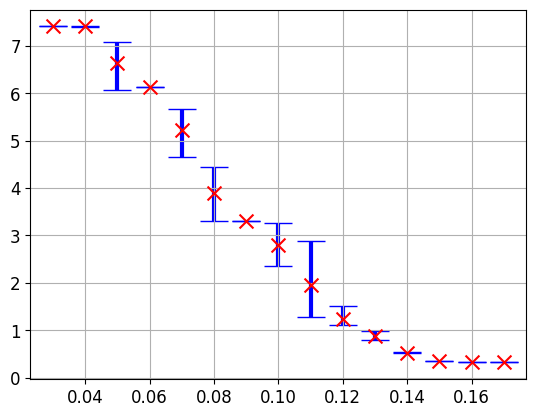

In [ ]:

fontsize = 20
axisfontsize = 12

resilient_reward_rangeub = np.array(PDrewardub)
resilient_reward_rangelb = np.array(PDrewardlb)
center = (resilient_reward_rangeub +resilient_reward_rangelb)/2
width = (resilient_reward_rangeub -resilient_reward_rangelb)/2

plt.errorbar(alpha_list, center, linestyle="None", yerr  = width, capsize = 10,  fmt = '' ,c='blue', linewidth=3, zorder = 1)
plt.scatter(alpha_list, optreward, label = 'optimistic', marker = 'x', color = 'red', s = 100, zorder = 2)

# plt.xscale('log')
# plt.legend()
plt.grid()
plt.savefig('reward.png')

plt.tick_params(axis='x', labelsize=axisfontsize)
plt.tick_params(axis='y', labelsize=axisfontsize)
# plt.text(0.05,8.07,'reward vs $\\alpha$', fontsize=16)
# plt.xlim(0.07,0.18)
plt.savefig('E2RewardVsAlpha.png', dpi = 300, bbox_inches='tight')
plt.show()

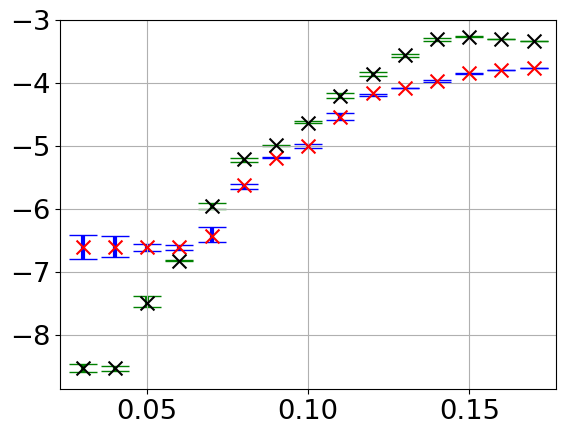

In [ ]:
resilient_xi_rangeub = np.array(PDxi1ub)
resilient_xi_rangelb = np.array(PDxi1lb)
center = (resilient_xi_rangeub +resilient_xi_rangelb)/2
width = (resilient_xi_rangeub -resilient_xi_rangelb)/2
axisfontsize = 19.7
resilient_xi2_rangeub = np.array(PDxi2ub)
resilient_xi2_rangelb = np.array(PDxi2lb)
center2 = (resilient_xi2_rangeub +resilient_xi2_rangelb)/2
width2 = (resilient_xi2_rangeub -resilient_xi2_rangelb)/2

plt.errorbar(alpha_list, center, linestyle="None", yerr  = width, capsize = 10,  fmt = '' ,c='blue', linewidth=3, zorder = 1)
plt.scatter(alpha_list, optxi1,label = 'optimistic', marker = 'x', color = 'red', s = 100, zorder = 2)

plt.errorbar(alpha_list, center2, linestyle="None", yerr  = width2, capsize = 10,  fmt = '' ,c='green', linewidth=3, zorder = 1)
plt.scatter(alpha_list, optxi2,label = 'optimistic', marker = 'x', color = 'black', s = 100, zorder = 2)
plt.grid()

plt.tick_params(axis='x', labelsize=axisfontsize)
plt.tick_params(axis='y', labelsize=axisfontsize)
# plt.ylim(-6.2,-2.0)
# plt.xlim(0.07,0.19)


plt.savefig('E2XiVsAlphav2.png', dpi = 300, bbox_inches='tight')
plt.show()

## Plot reward, utility and relaxation vs iterations

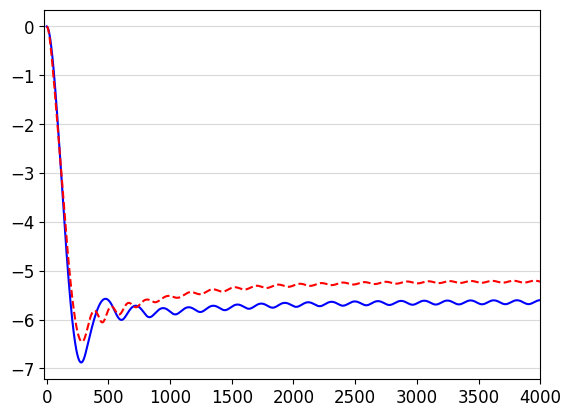

In [ ]:
yaxixmax = 4000
fontsize = 28
axisfontsize = 12

num_every = 1
num_grads = np.arange(0, yaxixmax, num_every)
index = 5
plot = 'xi' #xi, utility, reward
method = 'ResPG-PD' #ResOPG-PD

if plot == 'xi' and method == 'ResOPG-PD':
  plt.plot(num_grads,opt_resilient_xi1[index][:yaxixmax][::num_every], color = 'blue')
  plt.plot(num_grads,opt_resilient_xi2[index][:yaxixmax][::num_every], color = 'green',linestyle= '-')

if plot == 'xi' and method == 'ResPG-PD':
  plt.plot(num_grads,resilient_xi1[index][:yaxixmax][::num_every], color = 'blue')
  plt.plot(num_grads,resilient_xi2[index][:yaxixmax][::num_every],  color = 'red', linestyle = '--')


if plot == 'reward' and method == 'ResOPG-PD':
  plt.plot(num_grads,opt_resilient_reward[index][:yaxixmax][::num_every], color = 'red')

if plot == 'reward' and method == 'ResPG-PD':
  plt.plot(num_grads,resilient_reward[index][:yaxixmax][::num_every], color = 'red', linestyle = '-')


# We move the initial constraints to the left side when recording. So we move them back when plotting
if plot == 'utility' and method == 'ResOPG-PD':
# if True:
  plt.plot(num_grads,np.array(opt_resilient_utility1[index][:yaxixmax][::num_every])+u_constraint1, color = 'blue')
  plt.plot(num_grads,np.array(opt_resilient_utility2[index][:yaxixmax][::num_every])+u_constraint2, color = 'green', linestyle = '--')

if plot == 'utility' and method == 'ResPG-PD':
# if True:
  plt.plot(num_grads,np.array(resilient_utility1[index][:yaxixmax][::num_every])+u_constraint1, color = 'blue', linestyle = '-')
  plt.plot(num_grads,np.array(resilient_utility2[index][:yaxixmax][::num_every])+u_constraint2, color = 'green', linestyle = '--')



plt.grid(axis='y', color='0.85')
plt.draw()
get_f_value = plt.gcf()
plt.xlim(-20,yaxixmax)
plt.tick_params(axis='x', labelsize=axisfontsize)
plt.tick_params(axis='y', labelsize=axisfontsize)
# plt.yscale('log')
plt.savefig('E3UtilityVsIternopt.png', dpi = 300, bbox_inches='tight')
plt.show()

# print("u1,blue:")
# print(np.array(opt_resilient_utility1[index][:yaxixmax][::num_every])[-1]-np.array(resilient_utility1[index][:yaxixmax][::num_every])[-1])
# print("u2,green:")
# print(np.array(opt_resilient_utility2[index][:yaxixmax][::num_every])[-1]-np.array(resilient_utility2[index][:yaxixmax][::num_every])[-1])

## Plot reward, utility and relaxation optimality gaps

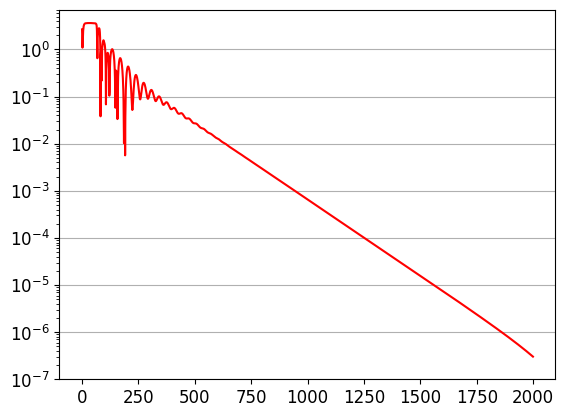

In [ ]:
# Reward
num_every = 1
yaxixmax = 2000
axisfontsize = 12
num_grads = np.arange(0, yaxixmax, num_every)
ymax = yaxixmax
index = 0

a = 0.08

method = 'ResOPG-PD' #ResPG-PD

if method == 'ResPG-PD':
  plt.plot(num_grads,np.abs(np.array(resilient_reward[index][:ymax])- optimal_dict[a, a]['reward'])[0][::num_every], color = 'red')

if method == 'ResOPG-PD':
  plt.plot(num_grads,np.abs(np.array(opt_resilient_reward[index][:ymax])- optimal_dict[a, a]['reward'])[0][::num_every], color = 'red')

plt.yscale('log')
# plt.ylim(5e-10,7)
plt.ylim(1e-7,7)
# plt.xlim(0,2000)
plt.tick_params(axis='x', labelsize=axisfontsize)
plt.tick_params(axis='y', labelsize=axisfontsize)
ax = plt.gca()

# Add only horizontal grid lines
ax.yaxis.grid(True)
plt.savefig('E3RewardErrorvsIteropt.png', dpi = 300, bbox_inches='tight')
plt.show()

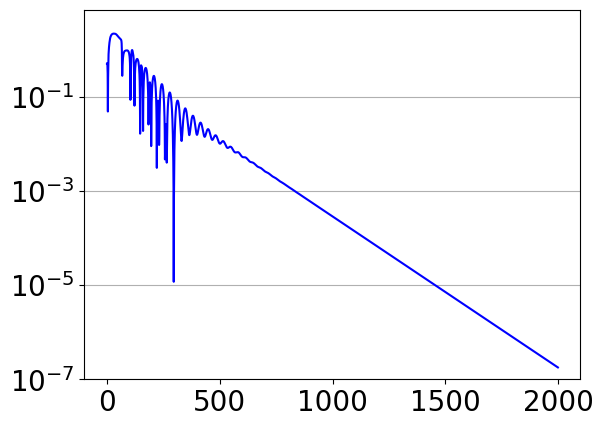

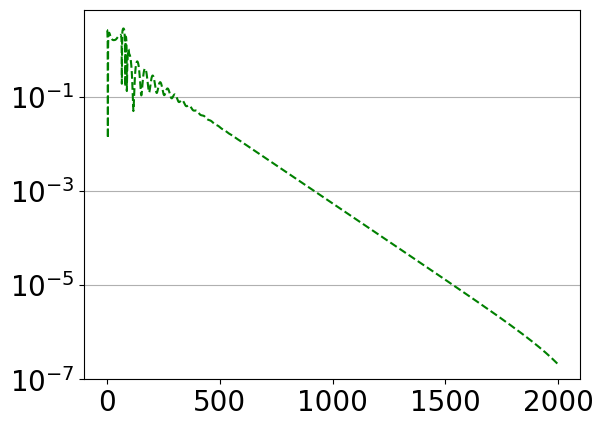

In [ ]:
#utility
num_every = 1
yaxixmax = 2000
axisfontsize = 20
num_grads = np.arange(0, yaxixmax, num_every)
ymax = yaxixmax
index = 0

a = 0.08

method = 'ResOPG-PD' #ResPG-PD

if method == 'ResPG-PD':
  plt.plot(num_grads,np.abs(np.array(resilient_utility1[index][:ymax])- optimal_dict[a, a]['utility1'])[0][::num_every], color = 'blue')

if method == 'ResOPG-PD':
  plt.plot(num_grads,np.abs(np.array(opt_resilient_utility1[index][:ymax])- optimal_dict[a, a]['utility1'])[0][::num_every], color = 'blue')
  # plt.plot(num_grads,np.abs(np.array(opt_resilient_utility2[index][:ymax])- optimal_dict[a, a]['utility2'])[0][::num_every],'--', color = 'red')

plt.yscale('log')
# plt.ylim(5e-10,7)
plt.ylim(1e-7,7)
# plt.xlim(0,2000)
plt.tick_params(axis='x', labelsize=axisfontsize)
plt.tick_params(axis='y', labelsize=axisfontsize)
ax = plt.gca()

# Add only horizontal grid lines
ax.yaxis.grid(True)
plt.savefig('E3Utility1ErrorvsIteropt.png', dpi = 300, bbox_inches='tight')
plt.show()



if method == 'ResPG-PD':
  plt.plot(num_grads,np.abs(np.array(resilient_utility2[index][:ymax])- optimal_dict[a, a]['utility2'])[0][::num_every],'--',color = 'green')

if method == 'ResOPG-PD':
  plt.plot(num_grads,np.abs(np.array(opt_resilient_utility2[index][:ymax])- optimal_dict[a, a]['utility2'])[0][::num_every],'--', color = 'green')

plt.yscale('log')
plt.ylim(5e-10,7)
plt.tick_params(axis='x', labelsize=axisfontsize)
plt.tick_params(axis='y', labelsize=axisfontsize)
ax = plt.gca()
plt.ylim(1e-7,7)
# Add only horizontal grid lines
ax.yaxis.grid(True)

plt.savefig('E3Utility2ErrorvsIteropt.png', dpi = 300, bbox_inches='tight')
plt.show()

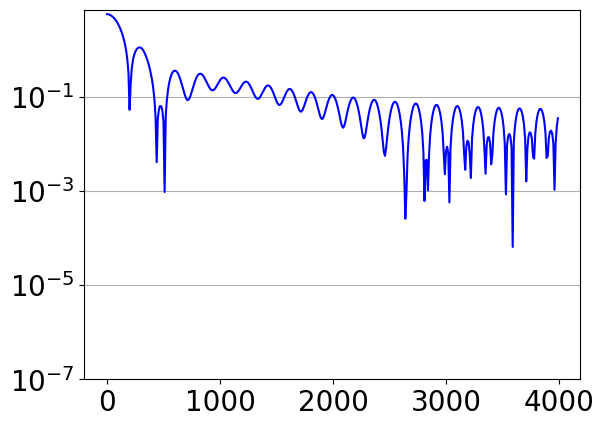

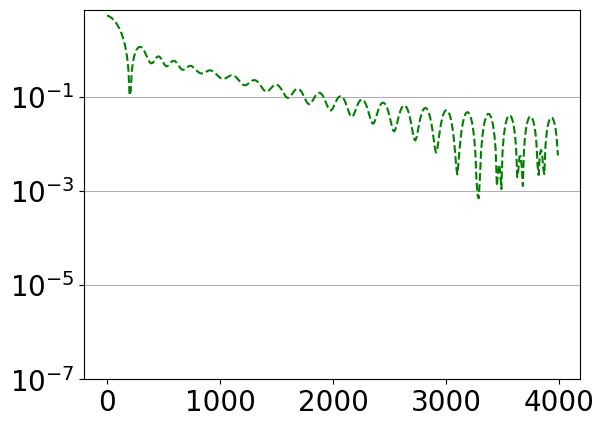

In [ ]:
#relaxation xi
num_every = 10
yaxixmax = 4000
axisfontsize = 20
num_grads = np.arange(0, yaxixmax, num_every)
ymax = yaxixmax
index = 0

a = 0.08

method = 'ResPG-PD' #ResPG-PD

if method == 'ResPG-PD':
  plt.plot(num_grads,np.abs(np.array(resilient_xi1[index][:ymax])- optimal_dict[a, a]['xi1'])[::num_every], color = 'blue')


if method == 'ResOPG-PD':
  plt.plot(num_grads,np.abs(np.array(opt_resilient_xi1[index][:ymax])- optimal_dict[a, a]['xi1'])[::num_every], color = 'blue')
  # plt.plot(num_grads,np.abs(np.array(opt_resilient_xi2[index][:ymax])- optimal_dict[a, a]['xi2'])[::num_every],'--', color = 'red')

plt.yscale('log')
# plt.ylim(5e-10,7)
plt.ylim(1e-7,7)
# plt.xlim(0,2000)
plt.tick_params(axis='x', labelsize=axisfontsize)
plt.tick_params(axis='y', labelsize=axisfontsize)
ax = plt.gca()

# Add only horizontal grid lines
ax.yaxis.grid(True)
plt.savefig('E3Xi1ErrorvsIternopt.png', dpi = 300, bbox_inches='tight')
plt.show()



if method == 'ResPG-PD':
  plt.plot(num_grads,np.abs(np.array(resilient_xi2[index][:ymax])- optimal_dict[a, a]['xi2'])[::num_every],'--',color = 'green')

if method == 'ResOPG-PD':
  plt.plot(num_grads,np.abs(np.array(opt_resilient_xi2[index][:ymax])- optimal_dict[a, a]['xi2'])[::num_every],'--', color = 'green')

plt.yscale('log')
plt.ylim(1e-7,7)
plt.tick_params(axis='x', labelsize=axisfontsize)
plt.tick_params(axis='y', labelsize=axisfontsize)
ax = plt.gca()

# Add only horizontal grid lines
ax.yaxis.grid(True)
plt.savefig('E3Xi2ErrorvsIternopt.png', dpi = 300, bbox_inches='tight')
plt.show()

## Visualize the policy

In [ ]:
# The trained policy from ResOPG-PD with alpha = 0.1

policy_alpha_0_1 = np.array([0.329492,0.000000,0.000000,0.670508,0.000000,0.000000,0.000000,1.000000
,0.185532,0.000000,0.000000,0.814468,0.186211,0.000000,0.000000,0.813789
,0.150605,0.000000,0.000000,0.849395,0.469531,0.000000,0.000000,0.530469
,0.300705,0.000000,0.000000,0.699295,0.129383,0.000000,0.197554,0.673063
,0.000000,0.291381,0.104568,0.604051,0.000000,0.567977,0.000000,0.432023
,0.849236,0.000000,0.000000,0.150764,0.000000,0.000000,0.000000,1.000000
,0.036148,0.000000,0.000000,0.963852,0.409751,0.000000,0.000000,0.590249
,0.186082,0.000000,0.000000,0.813918,1.000000,0.000000,0.000000,0.000000
,0.317400,0.000000,0.000000,0.682600,0.180309,0.489758,0.188323,0.141611
,0.135290,0.736376,0.125198,0.003136,0.073337,0.443562,0.000000,0.483101
,0.400293,0.000000,0.000000,0.599707,0.000000,0.000000,0.000000,1.000000
,0.268702,0.000000,0.000000,0.731298,0.020160,0.000000,0.000000,0.979840
,0.000000,0.000000,0.000000,1.000000,0.206837,0.000000,0.000000,0.793163
,0.525074,0.000000,0.474926,0.000000,0.273212,0.142456,0.225778,0.358554
,0.187324,0.479983,0.211579,0.121114,0.072220,0.778229,0.149551,0.000000
,0.374953,0.000000,0.000000,0.625047,0.000000,0.000000,0.000000,1.000000
,0.434778,0.000000,0.000000,0.565222,0.154250,0.000000,0.000000,0.845750
,0.360511,0.000000,0.000000,0.639489,0.000000,0.484272,0.000000,0.515728
,0.206851,0.294771,0.206851,0.291526,0.516172,0.000000,0.483828,0.000000
,0.000000,0.569481,0.430519,0.000000,0.000000,0.771824,0.228176,0.000000
,0.292470,0.000000,0.000000,0.707530,0.000000,0.000000,0.000000,1.000000
,0.969419,0.000000,0.000000,0.030581,0.230840,0.000000,0.000000,0.769160
,0.164652,0.284876,0.143377,0.407095,0.025820,0.487802,0.046343,0.440035
,0.000000,0.544991,0.000000,0.455009,0.000000,0.793134,0.206866,0.000000
,0.000000,0.000000,1.000000,0.000000,0.000000,0.326273,0.673727,0.000000
,0.300063,0.000000,0.000000,0.699937,0.000000,0.000000,0.000000,1.000000
,0.000000,0.000000,0.000000,1.000000,0.481168,0.030732,0.457368,0.030732
,0.238621,0.393259,0.286387,0.081734,0.134304,0.344933,0.209519,0.311243
,0.000000,0.478000,0.522000,0.000000,0.000000,1.000000,0.000000,0.000000
,0.000000,0.813849,0.186151,0.000000,0.000000,0.849345,0.150655,0.000000
,0.391555,0.000000,0.000000,0.608445,0.211299,0.000000,0.000000,0.788701
,0.000000,0.571862,0.000000,0.428138,0.000000,0.491918,0.000000,0.508082
,0.394547,0.030788,0.543877,0.030788,0.000000,0.705833,0.294167,0.000000
,0.000000,0.809955,0.190045,0.000000,0.000000,0.680191,0.319809,0.000000
,0.000000,0.499263,0.500737,0.000000,0.000000,0.370450,0.629550,0.000000
,0.509906,0.412292,0.000000,0.077802,0.399455,0.299848,0.218341,0.082356
,0.012410,0.170879,0.267916,0.548795,0.000000,0.586597,0.000000,0.413403
,0.000000,1.000000,0.000000,0.000000,0.000000,0.030692,0.969308,0.000000
,0.000000,0.561149,0.438851,0.000000,0.000000,0.805597,0.194403,0.000000
,0.000000,0.948181,0.051819,0.000000,0.000000,0.929489,0.070511,0.000000
,0.425222,0.494495,0.080283,0.000000,0.006782,0.393860,0.554505,0.044853
,0.133409,0.544587,0.218249,0.103755,0.000000,0.643281,0.356719,0.000000
,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
,0.339290,0.000000,0.660710,0.000000,0.272525,0.000000,0.608732,0.118743
,0.000000,0.319799,0.429674,0.250526,0.000000,0.372577,0.627423,0.000000
,0.000000,0.815511,0.184489,0.000000,0.000000,0.898385,0.101615,0.000000
,0.000000,0.841873,0.158127,0.000000,0.000000,0.896581,0.103419,0.000000
,0.000000,0.767295,0.232705,0.000000,0.000000,0.475865,0.524135,0.000000])

resilient_policy_008 = np.array([0.293410,0.000000,0.000000,0.706590,0.006566,0.000000,0.000000,0.993434,
 0.033609,0.000000,0.000000,0.966391,0.682239,0.000000,0.000000,0.317761,
 0.000000,0.000000,0.000000,1.000000,0.794205,0.000000,0.000000,0.205795,
 0.221861,0.000000,0.000000,0.778139,0.132442,0.000000,0.301692,0.565866,
 0.000000,0.387780,0.105806,0.506415,0.000000,0.621101,0.000000,0.378899,
 0.313707,0.000000,0.000000,0.686293,0.031971,0.000000,0.000000,0.968029,
 0.022978,0.000000,0.000000,0.977022,0.484372,0.000000,0.000000,0.515628,
 0.000000,0.000000,0.000000,1.000000,0.916722,0.000000,0.000000,0.083278,
 0.241577,0.000000,0.000000,0.758423,0.187765,0.342965,0.209261,0.260009,
 0.155441,0.631972,0.128329,0.084258,0.081908,0.351088,0.000000,0.567004,
 0.124369,0.000000,0.000000,0.875631,0.051353,0.000000,0.000000,0.948647,
 0.157390,0.000000,0.000000,0.842610,0.407861,0.000000,0.000000,0.592139,
 0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,
 0.450865,0.085082,0.378971,0.085082,0.253471,0.412451,0.219520,0.114559,
 0.219168,0.598185,0.152553,0.030094,0.403987,0.477365,0.118648,0.000000,
 0.271163,0.000000,0.000000,0.728837,0.072488,0.000000,0.000000,0.927512,
 0.432605,0.000000,0.000000,0.567395,0.122948,0.000000,0.000000,0.877052,
 0.604386,0.000000,0.000000,0.395614,0.000000,0.443940,0.000000,0.556060,
 0.000000,0.500027,0.000000,0.499973,0.432023,0.086528,0.394920,0.086528,
 0.000000,0.613345,0.386655,0.000000,0.000000,0.807867,0.192133,0.000000,
 0.218140,0.000000,0.000000,0.781860,0.036473,0.000000,0.000000,0.963527,
 1.000000,0.000000,0.000000,0.000000,0.228981,0.000000,0.000000,0.771019,
 0.148682,0.176984,0.096620,0.577714,0.012627,0.364610,0.246896,0.375866,
 0.000000,0.544907,0.000000,0.455093,0.000000,1.000000,0.000000,0.000000,
 0.000000,0.086171,0.913829,0.000000,0.000000,0.587699,0.412301,0.000000,
 0.111355,0.000000,0.000000,0.888645,0.000000,0.000000,0.000000,1.000000,
 0.335431,0.000000,0.000000,0.664569,0.528769,0.000000,0.471231,0.000000,
 0.231191,0.435020,0.219936,0.113853,0.095026,0.772390,0.124796,0.007789,
 0.000000,0.384503,0.615497,0.000000,0.000000,1.000000,0.000000,0.000000,
 0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,
 0.193579,0.000000,0.000000,0.806421,0.686268,0.000000,0.000000,0.313732,
 0.000000,0.469986,0.000000,0.530014,0.048474,0.412234,0.050159,0.489133,
 0.481087,0.000000,0.518913,0.000000,0.000000,0.777854,0.222146,0.000000,
 0.000000,0.875761,0.124239,0.000000,0.000000,0.591113,0.408887,0.000000,
 0.000000,0.517369,0.482631,0.000000,0.000000,0.638581,0.361419,0.000000,
 0.045565,0.736038,0.000000,0.218397,0.205053,0.537306,0.062054,0.195586,
 0.263181,0.290636,0.293094,0.153089,0.000000,0.325162,0.000000,0.674838,
 0.000000,0.679316,0.320684,0.000000,0.000000,0.000000,1.000000,0.000000,
 0.000000,0.567806,0.432194,0.000000,0.000000,0.842531,0.157469,0.000000,
 0.000000,0.977765,0.022235,0.000000,0.000000,0.975891,0.024109,0.000000,
 0.590958,0.010045,0.398997,0.000000,0.088813,0.452470,0.053357,0.405360,
 0.012457,0.218633,0.455988,0.312922,0.000000,0.472243,0.527757,0.000000,
 0.000000,1.000000,0.000000,0.000000,0.000000,0.966147,0.033853,0.000000,
 0.000000,0.935465,0.064535,0.000000,0.000000,0.956219,0.043781,0.000000,
 0.000000,0.974670,0.025330,0.000000,0.000000,0.987090,0.012910,0.000000,
 0.281315,0.000000,0.718685,0.000000,0.139575,0.000000,0.358754,0.501670,
 0.000000,0.140180,0.621064,0.238755,0.000000,0.492715,0.507285,0.000000,
 0.000000,0.702066,0.297934,0.000000,0.000000,0.352045,0.647955,0.000000,
 0.000000,0.680389,0.319611,0.000000,0.000000,0.803454,0.196546,0.000000,
 0.000000,0.608302,0.391698,0.000000,0.000000,0.341829,0.658171,0.000000])

non_resilient_policy = np.array([0.099634,0.000000,0.000000,0.900366,0.000000,0.000000,0.000000,1.000000,
 0.000000,0.000000,0.000000,1.000000,0.622725,0.000000,0.000000,0.377275,
 0.789247,0.000000,0.000000,0.210753,0.844588,0.000000,0.000000,0.155412,
 0.392061,0.000000,0.000000,0.607939,0.247719,0.000000,0.151052,0.601229,
 0.000000,0.107997,0.493707,0.398296,0.000000,0.376119,0.000000,0.623881,
 0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,
 0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,
 1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,
 0.554701,0.000000,0.000000,0.445299,0.560967,0.000014,0.000000,0.439018,
 0.382455,0.120600,0.019825,0.477120,0.275376,0.192209,0.000000,0.532415,
 0.055362,0.000000,0.000000,0.944638,0.000000,0.000000,0.000000,1.000000,
 0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,
 1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,
 0.788196,0.000000,0.211804,0.000000,0.363402,0.141601,0.228695,0.266302,
 0.099612,0.097125,0.254625,0.548638,0.133151,0.781593,0.085256,0.000000,
 0.391719,0.000000,0.000000,0.608281,0.000000,0.000000,0.000000,1.000000,
 0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,
 1.000000,0.000000,0.000000,0.000000,0.620716,0.000000,0.379284,0.000000,
 0.356522,0.000000,0.643478,0.000000,0.556995,0.000000,0.443005,0.000000,
 0.000000,0.083408,0.916592,0.000000,0.000000,0.669414,0.330586,0.000000,
 0.151620,0.000000,0.000000,0.848380,0.000000,0.000000,0.000000,1.000000,
 0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,
 0.000000,0.044970,0.000000,0.955030,0.527334,0.000000,0.472666,0.000000,
 0.295185,0.000000,0.704815,0.000000,0.000000,0.000000,1.000000,0.000000,
 0.000000,0.000000,1.000000,0.000000,0.000000,0.407456,0.592544,0.000000,
 0.816325,0.000000,0.000000,0.183675,0.000000,0.000000,0.000000,1.000000,
 0.000000,0.000000,0.000000,1.000000,0.000000,0.395871,0.000000,0.604129,
 0.000000,0.681558,0.000000,0.318442,0.000000,0.832015,0.000000,0.167985,
 0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,
 0.000000,0.000000,1.000000,0.000000,0.000000,0.410042,0.589958,0.000000,
 0.489936,0.000000,0.000000,0.510064,0.146561,0.000000,0.000000,0.853439,
 0.000000,0.704843,0.000000,0.295157,0.000000,0.411623,0.000000,0.588377,
 0.000000,0.761269,0.000000,0.238731,0.000000,1.000000,0.000000,0.000000,
 0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,
 0.000000,0.000000,1.000000,0.000000,0.000000,0.426342,0.573658,0.000000,
 0.698442,0.199275,0.000000,0.102283,0.346542,0.549165,0.000321,0.103973,
 0.041485,0.526010,0.223709,0.208796,0.000000,0.402448,0.000000,0.597552,
 0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,
 0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,
 0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,
 0.008229,0.604118,0.387653,0.000000,0.000000,0.590442,0.409558,0.000000,
 0.023533,0.674063,0.034831,0.267573,0.000000,0.514297,0.485703,0.000000,
 0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,
 0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,
 0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,
 0.394007,0.000000,0.605993,0.000000,0.528708,0.000000,0.405918,0.065373,
 0.000000,0.412773,0.473227,0.114000,0.000000,0.323016,0.676984,0.000000,
 0.000000,0.844579,0.155421,0.000000,0.000000,0.797469,0.202531,0.000000,
 0.000000,0.545519,0.454481,0.000000,0.000000,0.659134,0.340866,0.000000,
 0.000000,0.674993,0.325007,0.000000,0.000000,0.855090,0.144910,0.000000])

In [ ]:
def calarrow(mat, length, width):
    output = np.zeros([length, width, 2])
    for i in range(length*width):
        up = mat[4 * i + 0]
        down = mat[4 * i + 1]
        left = mat[4 * i + 2]
        right = mat[4 * i + 3]
        xarrow = right - left
        yarrow = up -down
        # print(xarrow,yarrow)

        x,y = state2coordinate(i, length, width)
        output[x,y,0] = xarrow
        output[x, y, 1] = yarrow

    return output

def plotarrow(arrowmat, scale):
    length = arrowmat.shape[0]
    width = arrowmat.shape[1]
    for i in range(length):
        for j in range(width):
            xarrow = arrowmat[i,j,0]*scale
            yarrow = arrowmat[i,j,1]*scale

            plt.arrow(i, j, xarrow,  yarrow, head_width=0.2, head_length=0.2, fc='grey', ec='grey',alpha = 0.9)


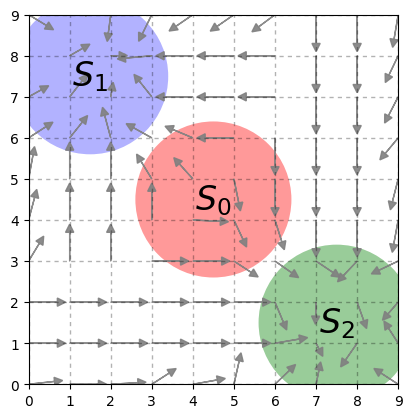

In [ ]:


# Create a 10x10 grid
grid_size = 9
x = range(grid_size + 1)
y = range(grid_size + 1)


for i in x:
    plt.axvline(x=i, color='black', linestyle='--', linewidth=1, dashes=(3, 3), alpha = 0.3)


for i in y:
    plt.axhline(y=i, color='black', linestyle='--', linewidth=1, dashes=(3, 3), alpha = 0.3)


plt.xlim(0, grid_size)
plt.ylim(0, grid_size)


plt.gca().set_aspect('equal', adjustable='box')

plt.xticks(range(grid_size + 1))
plt.yticks(range(grid_size + 1))

# Show the grid
plt.grid(False)
circle = plt.Circle((4.5, 4.5), 1.9, edgecolor='none', facecolor='red', linewidth=2, alpha = 0.4)
plt.gca().add_patch(circle)
circle = plt.Circle((1.5, 7.5), 1.9, edgecolor='none', facecolor='blue', linewidth=2, alpha = 0.3)
plt.gca().add_patch(circle)
circle = plt.Circle((7.5, 1.5), 1.9, edgecolor='none', facecolor='green', linewidth=2, alpha = 0.4)
plt.gca().add_patch(circle)
# Display the plot

arrowmat = calarrow(non_resilient_policy, length, width)
# non_resilient_policy
# resilient_policy_008

plotarrow(arrowmat,0.7)

plt.text(4.5, 4.5, '$S_0$', ha='center', va='center', fontsize = 24)
plt.text(1.5, 7.5, '$S_1$', ha='center', va='center', fontsize = 24)
plt.text(7.5, 1.5, '$S_2$', ha='center', va='center', fontsize = 24)

plt.savefig('nonresilientgrid.png', dpi = 300, bbox_inches='tight')
plt.show()